# **Targeted Sentiment Analysis**, *a.k.a. Aspect Based Sentiment Analysis (ABSA).*

### Overview

This notebook higlights some differences with the baseline provided by the University of Oslo and PyTorch standards.
Some classes are re-defined, and is a bit confusing as pytorch offers the same, in better. In addition, some elements are not transformed correctly with the script provided.

### Goal

Set up a PyTorch script, doing the same (but different) than UiO baseline script.

# **0. Set Up**

Before diving in the models, let's reload the notebook to keep it updated.

In [1]:
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.style.use('seaborn-darkgrid')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Then, let's load the dependencies:

In [2]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
from torchtext import datasets

from torch.nn.utils.rnn import pad_packed_sequence, PackedSequence
from torch.utils.data import DataLoader

# Data science
import spacy
import numpy as np
import time
import random

In [3]:
#Let's not forget to fix the seed for random generated numbers !
SEED = 2020 

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **Baseline**


# 1. Dataset

### 1.1. NoReC fine

In [4]:
from torchtext.datasets import SequenceTaggingDataset


class NoReCfine(SequenceTaggingDataset):
    def __init__(self, path, fields, encoding="utf-8", separator="\t", **kwargs):
        super().__init__(path, fields)

    @classmethod
    def splits(cls, fields, train_data="data/train.conll", dev_data="data/dev.conll", test_data="data/test.conll"):
        return NoReCfine(train_data, fields), NoReCfine(dev_data, fields), NoReCfine(test_data, fields)

In [5]:
import torchtext

TEXT = torchtext.data.Field(lower=False, include_lengths=True, batch_first=True)
LABEL = torchtext.data.Field(batch_first=True, unk_token=None)
FIELDS = [("text", TEXT), ("label", LABEL)]

train_data, eval_data, test_data = NoReCfine.splits(FIELDS)

In [6]:
print(f'Number of training examples: {len(train_data):,}')
print(f'Number of training examples: {len(eval_data):,}')
print(f'Number of testing examples:    {len(test_data)}')

text_length = [len(sentence) for sentence in list(train_data.text)]

print(f"\nNumber of sentences in train_data.text: {len(text_length)}")
print(f'Number of words in train_data: {sum(text_length):,}')

Number of training examples: 5,915
Number of training examples: 1,151
Number of testing examples:    895

Number of sentences in train_data.text: 5915
Number of words in train_data: 98,483


In [7]:
print("What's inside the training data:")
print(vars(train_data[0]))

What's inside the training data:
{'text': ['Lite', 'tight', 'Tempah'], 'label': ['O', 'O', 'B-targ-Negative']}


### 1.2. Vocabulary

In [8]:
from torchtext.vocab import Vectors

VOCAB_SIZE = 1_200_000
VECTORS = Vectors(name='model.txt')

# Create the vocabulary for words embeddings
TEXT.build_vocab(train_data, 
                 max_size = VOCAB_SIZE, 
                 vectors = VECTORS, 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

### 1.2. Data Analysis

In [9]:
VECTORS.vectors.shape

torch.Size([1182371, 100])

In [10]:
TEXT.vocab.vectors.shape

torch.Size([19192, 100])

In [11]:
print("Vocabulary defined on the training data, with the help of pre-trained embeddings:\n")

print(TEXT.vocab.itos[0:20])

Vocabulary defined on the training data, with the help of pre-trained embeddings:

['<unk>', '<pad>', '.', ',', 'og', 'er', 'i', 'som', 'en', 'det', 'på', 'å', 'av', 'med', 'til', 'for', '«', '»', 'har', 'den']


In [12]:
print(f"The word '{TEXT.vocab.itos[8867]}' is not part of the pre-trained embeddings.\n")

print(f"PyTorch sets its vector to zero:\n{TEXT.vocab.vectors[8867]}")

The word 'Martel' is not part of the pre-trained embeddings.

PyTorch sets its vector to zero:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


In [13]:
print("Vocabulary informations:\n")
print(f"Labels vocabulary:\n{LABEL.vocab.itos}\n")
print(f"Text vocabulary:\n{TEXT.vocab.itos[:10]}\n")
print(f"Most frequent words:\n{TEXT.vocab.freqs.most_common(10)}")

Vocabulary informations:

Labels vocabulary:
['<pad>', 'O', 'I-targ-Positive', 'B-targ-Positive', 'I-targ-Negative', 'B-targ-Negative']

Text vocabulary:
['<unk>', '<pad>', '.', ',', 'og', 'er', 'i', 'som', 'en', 'det']

Most frequent words:
[('.', 4585), (',', 4085), ('og', 2878), ('er', 2326), ('i', 2071), ('som', 1699), ('en', 1628), ('på', 1318), ('det', 1318), ('å', 1222)]


### 1.3. Iterators

In [14]:
BATCH_SIZE = 64

device = torch.device('cpu')

train_iterator, eval_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, eval_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

# 2. Model

### 2.1. BiLSTM

In [15]:
class BiLSTM(nn.Module):

    def __init__(self,
                 input_dim,
                 embedding_dim=100,
                 hidden_dim=128,
                 output_dim=7,
                 n_layers=2,
                 bidirectional=True,
                 dropout=0.25,
                 pad_idx_text=1,
                 unk_idx_text=0,
                 pad_idx_label=0,
                 embeddings=None):
        super().__init__()
        # dimensions
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim

        # modules
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx_text)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional, batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

        if embeddings is not None:
            ignore_index = [idx for idx in [pad_idx_text, unk_idx_text] if idx is not None]
            self.init_embeddings(embeddings, ignore_index=ignore_index)

        # tokens
        self.pad_idx_text = pad_idx_text
        self.pad_idx_label = pad_idx_label
        self.unk_idx_text = unk_idx_text

    def init_embeddings(self, embeddings, ignore_index=None):
        r"""Initialize the embeddings vectors from pre-trained embeddings vectors.

        .. Warning::

            By default, the embeddings will set to zero the tokens at indices 0 and 1,
            that should corresponds to <pad> and <unk>.


        Examples::

            >>> # TEXT: field used to extract text, sentences etc.
            >>> PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
            >>> UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
            >>> pretrained_embeddings = TEXT.vocab.vectors

            >>> model.init_embeddings(pretrained_embeddings, ignore_index=[PAD_IDX, UNK_IDX])


        Args:
            embeddings (torch.tensor): pre-trained word embeddings, of shape ``(input_dim, embedding_dim)``.
            ignore_index (int or iterable): if not `None`, set to zeros tensors at the indices provided.

        """
        self.embedding.weight.data.copy_(embeddings)
        if ignore_index is not None:
            if isinstance(ignore_index, int):
                self.embedding.weight.data[ignore_index] = torch.zeros(self.embedding_dim)
            elif isinstance(ignore_index, list) or isinstance(ignore_index, tuple):
                for index in ignore_index:
                    self.embedding.weight.data[index] = torch.zeros(self.embedding_dim)
            elif isinstance(ignore_index, dict):
                raise KeyError("Ambiguous `ignore_index` provided. "
                               "Please provide an iterable like a `list` or `tuple`.")

    def forward(self, text, length):
        r"""One forward step.

        .. note::

            The forward propagation requires text's length, so a padded pack can be applied to batches.

        Args:
            text (torch.tensor): text composed of word embeddings vectors from one batch.
            length (torch.tensor): vector indexing the lengths of `text`.


        Examples::

            >>> for batch in data_iterator:
            >>>     text, length = batch.text
            >>>     model.forward(text, length)

        """
        # Word embeddings
        embeddings = self.embedding(text)
        # Apply a dropout
        embedded = self.dropout(embeddings)
        # Pack and pad a batch
        packedembeds = nn.utils.rnn.pack_padded_sequence(embedded, length, batch_first=True)
        # Apply the recurrent cell
        packed_output, h_n = self.lstm(packedembeds)
        # Predict
        output = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)[0]
        # Apply another dropout and a linear layer for classification tasks
        predictions = self.fc(self.dropout(output))

        return predictions

In [16]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(LABEL.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25
PAD_IDX_TEXT = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX_TEXT = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX_LABEL = LABEL.vocab.stoi[LABEL.pad_token]


model = BiLSTM(INPUT_DIM, 
               EMBEDDING_DIM, 
               HIDDEN_DIM, 
               OUTPUT_DIM, 
               N_LAYERS, 
               BIDIRECTIONAL, 
               DROPOUT, 
               pad_idx_text = PAD_IDX_TEXT,
               unk_idx_text = UNK_IDX_TEXT,
               pad_idx_label = PAD_IDX_LABEL)

Next, we define our loss function, cross-entropy loss.

Even though we have no `<unk>` tokens within our tag vocab, we still have `<pad>` tokens. This is because all sentences within a batch need to be the same size. However, we don't want to calculate the loss when the target is a `<pad>` token as we aren't training our model to recognize padding tokens.

We handle this by setting the `ignore_index` in our loss function to the index of the padding token in our tag vocabulary.

In [17]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX_LABEL)

model = model           #.to(device)
criterion = criterion   #.to(device)

### 2.2. Initialize weights with pretrained vectors 

In [18]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([19192, 100])


In [19]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0693,  0.0041,  0.2020,  ...,  0.1263,  0.0421,  0.0982],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7025,  0.0027,  0.5114,  ...,  0.6630, -0.1983, -0.4008],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

As our `<unk>` and `<pad>` token aren't in the pre-trained vocabulary they have been initialized using `unk_init` (an $\mathcal{N}(0,1)$ distribution) when building our vocab. It is preferable to initialize them both to all zeros to explicitly tell our model that, initially, they are irrelevant for determining sentiment. 

We do this by manually setting their row in the embedding weights matrix to zeros. We get their row by finding the index of the tokens, which we have already done for the padding index.

**Note**: like initializing the embeddings, this should be done on the `weight.data` and not the `weight`!

In [20]:
# Reminder:
# PAD_IDX_TEXT = TEXT.vocab.stoi[TEXT.pad_token]
# UNK_IDX_TEXT = TEXT.vocab.stoi[TEXT.unk_token]
# PAD_IDX_LABEL = LABEL.vocab.stoi[LABEL.pad_token]

model.embedding.weight.data[UNK_IDX_TEXT] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX_TEXT] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0693,  0.0041,  0.2020,  ...,  0.1263,  0.0421,  0.0982],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7025,  0.0027,  0.5114,  ...,  0.6630, -0.1983, -0.4008],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


We can now see the first two rows of the embedding weights matrix have been set to zeros. As we passed the index of the pad token to the `padding_idx` of the embedding layer it will remain zeros throughout training, however the `<unk>` token embedding will be learned.

# 3. Training

In [21]:
from sentarget.utils import progress_bar, describe_dict
from sentarget.nn import Solver
from sentarget.metrics import ConfusionMatrix

class SolverBiLSTM(Solver):
    # Performer for the bidirectional LSTM model
    
    def __init__(self, model=None, criterion=None, optimizer=None):
        super().__init__(model, criterion, optimizer)
    
    def get_accuracy(self, y_tilde, y, pad_idx_label=0):
        r"""Computes the accuracy from a set of predictions and gold labels.

        Args:
            y_tilde (torch.tensor): predictions.
            y (torch.tensor): gold labels.

        Returns:
            torch.tensor: the global accuracy, of shape 0.

        """
        non_pad_elements = (y != pad_idx_label).nonzero()
        correct = y_tilde[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
        top = correct.sum()
        bottom = torch.FloatTensor([y[non_pad_elements].shape[0]])
        accuracy = correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]])
        # Handles division by 0
        accuracy = accuracy if not torch.isnan(accuracy) else torch.tensor(0)
        return accuracy

    def train(self, iterator, pad_idx_label=0, verbose=True):
        r"""Train one time the model on iterator data.

        Args:
            iterator (Iterator): iterator containing batch samples of data.
            pad_idx_label (int): index of padding elements.
            verbose (bool): if `True` display a progress bar.

        Returns:
            dict: the performance and metrics of the training session.

        """
        # Initialize the variables
        start_time = time.time()
        epoch_loss = 0
        epoch_acc = 0
        class_labels = list(range(self.model.output_dim))
        class_labels.pop(self.model.pad_idx_label)
        confusion_matrix = ConfusionMatrix(labels=class_labels)

        # Train mode
        self.model.train()
        for (idx, batch) in enumerate(iterator):
            self.optimizer.zero_grad()
            # One forward step
            text, length = batch.text
            y_hat = self.model.forward(text, length)
            y_hat = y_hat.view(-1, y_hat.shape[-1])
            label = batch.label.view(-1)
            # Get the predicted classes
            y_tilde = y_hat.argmax(dim=1, keepdim=True)
            # Compute the loss and update the weights
            loss = self.criterion(y_hat, label)
            loss.backward()
            self.optimizer.step()
            epoch_loss += loss.item()
            # Default accuracy
            acc = self.get_accuracy(y_tilde, label)
            epoch_acc += acc.item()
            # Optional: display a progress bar
            if verbose:
                progress_bar(idx, len(iterator) - 1, prefix="Training:\t", start_time=start_time)

            # Update the confusion matrix
            confusion_matrix.update(label.long().numpy(), y_tilde.long().numpy())

        # Store the loss, accuracy and metrics in a dictionary
        results_train = {"loss": epoch_loss / len(iterator),
                         "accuracy": epoch_acc / len(iterator),
                         **confusion_matrix.to_dict()
                         }

        return results_train

    def evaluate(self, iterator, pad_idx_label=0, verbose=True):
        r"""Evaluate one time the model on iterator data.

        Args:
            iterator (Iterator): iterator containing batch samples of data.
            pad_idx_label (int): index of padding elements.
            verbose (bool): if `True` display a progress bar.

        Returns:
            dict: the performance and metrics of the training session.

        """
        # Initialize the variables
        start_time = time.time()
        epoch_loss = 0
        epoch_acc = 0
        class_labels = list(range(self.model.output_dim))
        class_labels.pop(self.model.pad_idx_label)
        confusion_matrix = ConfusionMatrix(labels=class_labels)
        
        # Eval mode
        self.model.eval()
        with torch.no_grad():
            for (idx, batch) in enumerate(iterator):
                # One forward step
                text, length = batch.text
                y_hat = self.model.forward(text, length)
                y_hat = y_hat.view(-1, y_hat.shape[-1])
                label = batch.label.view(-1)
                # Get the predicted classes
                y_tilde = y_hat.argmax(dim=1, keepdim=True)
                # Compute the loss
                loss = self.criterion(y_hat, label)
                epoch_loss += loss.item()
                # Default accuracy
                acc = self.get_accuracy(y_tilde, label)
                epoch_acc += acc.item()
                # Optional: display a progress bar
                if verbose:
                    progress_bar(idx, len(iterator) - 1, prefix="Evaluation:\t", start_time=start_time)

                # Update the confusion matrix
                confusion_matrix.update(label.numpy(), y_tilde.numpy())

        # Store the loss, accuracy and metrics in a dictionary
        results_eval = {"loss": epoch_loss / len(iterator),
                        "accuracy": epoch_acc / len(iterator),
                        **confusion_matrix.to_dict()
                        }

        return results_eval

In [22]:
solver = SolverBiLSTM(model, criterion=criterion, optimizer=optimizer)

In [23]:
# Train & eval EPOCHS times
EPOCHS = 5
solver.fit(train_iterator, eval_iterator, PAD_IDX_LABEL, epochs=EPOCHS, verbose=True)

Epoch:	  1/5
Training:	 100% | [==================================================] | Time:  1m 35s | Done !
Evaluation:	 100% | [==================================================] | Time:  0m  2s | Done !
	 Stats Train: | Loss: 0.4787 | Accu: 0.9227 | Scor: 0.8972 | Prec: 0.1581 | Reca: 0.1668 | F1_s: 0.1616
	  Stats Eval: | Loss: 0.3205 | Accu: 0.9360 | Scor: 0.8073 | Prec: 0.1559 | Reca: 0.1667 | F1_s: 0.1611

Epoch:	  2/5
Training:	 100% | [==================================================] | Time:  1m 32s | Done !
Evaluation:	 100% | [==================================================] | Time:  0m  2s | Done !
	 Stats Train: | Loss: 0.2828 | Accu: 0.9386 | Scor: 0.9065 | Prec: 0.1514 | Reca: 0.1667 | F1_s: 0.1587
	  Stats Eval: | Loss: 0.2795 | Accu: 0.9360 | Scor: 0.8073 | Prec: 0.1346 | Reca: 0.1667 | F1_s: 0.1489

Epoch:	  3/5
Training:	 100% | [==================================================] | Time:  1m 32s | Done !
Evaluation:	 100% | [==================================

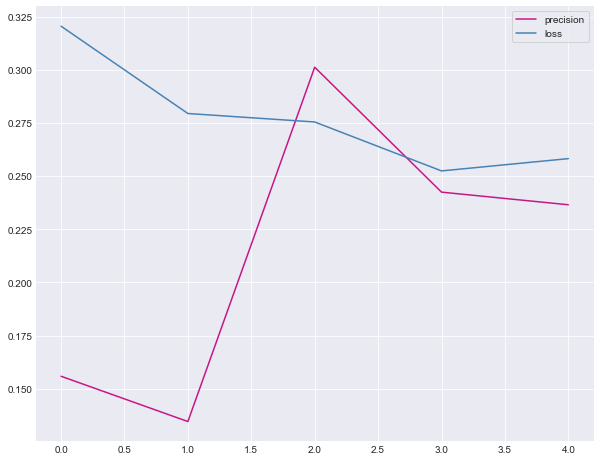

In [26]:
plt.plot(np.arange(EPOCHS), solver.performance['eval']['precision'], label="precision", color="mediumvioletred")
plt.plot(np.arange(EPOCHS), solver.performance['eval']['loss'], label="loss", color="steelblue")
plt.legend(frameon=True, loc=1)

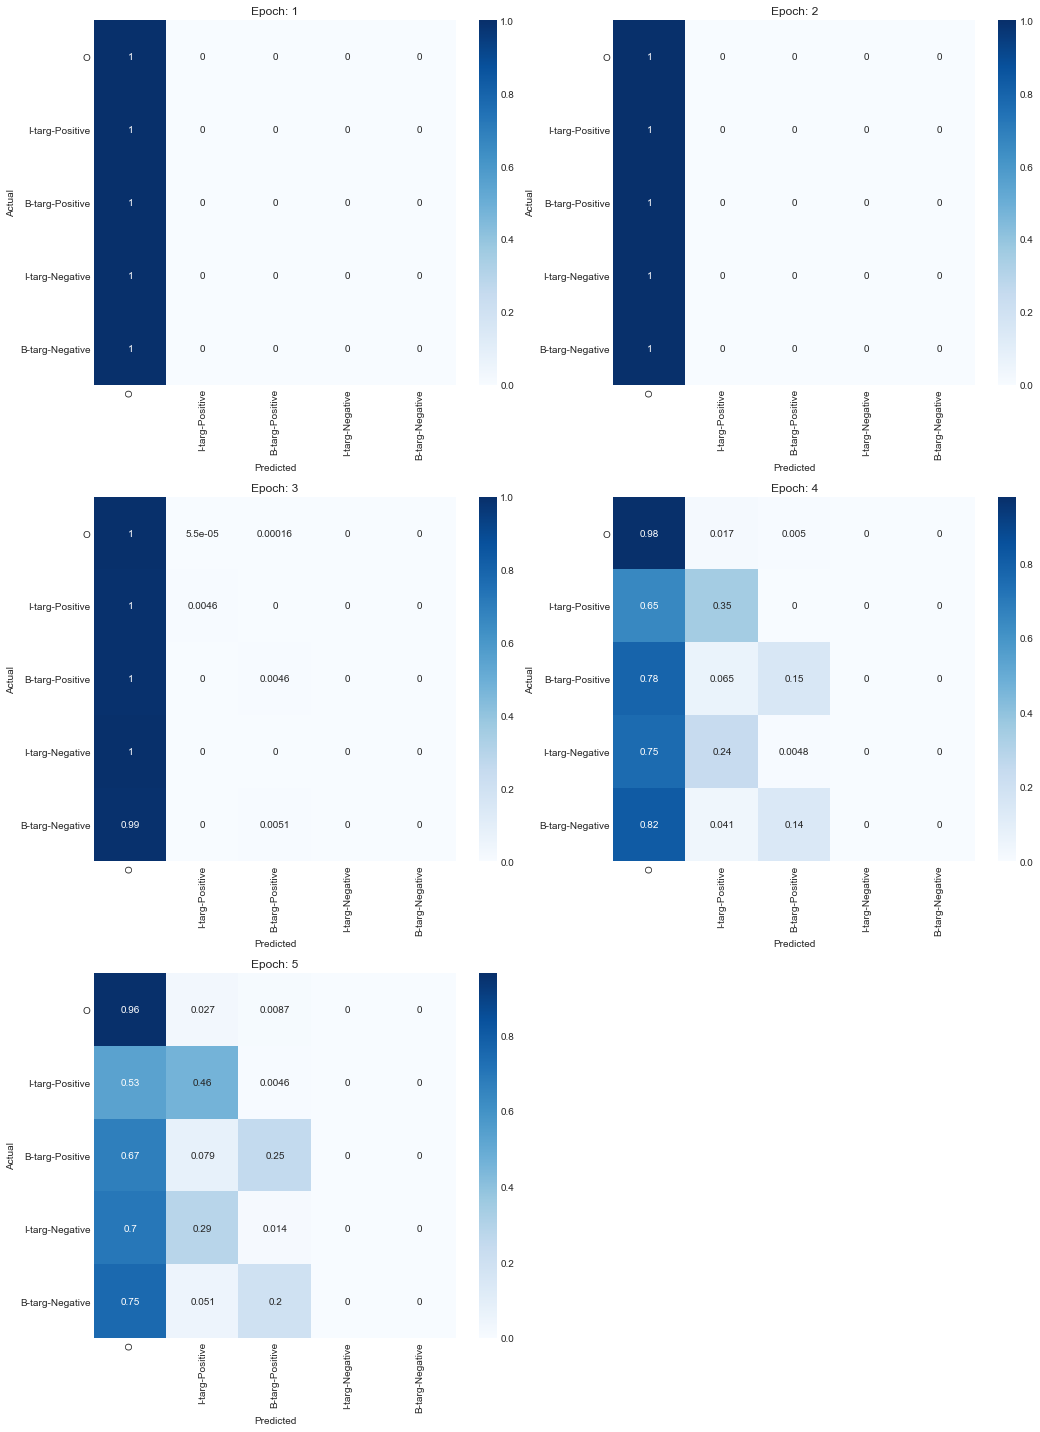

In [55]:
fig = plt.figure(figsize=(15, 20))

N = len(solver.performance['eval']['confusion'])  # should be equal to EPOCHS
names = LABEL.vocab.itos[1:]  # names of classes, ignore unk and pad

for i, data in enumerate(solver.performance['eval']['confusion']):
    plt.subplot(N//2 + N%2, 2, i+1)
    confusion = ConfusionMatrix(data=data)
    ax = confusion.plot(names=names, normalize=True, cbar=True)
    plt.title(f"Epoch: {i+1}")
    plt.tight_layout()
    
plt.show()